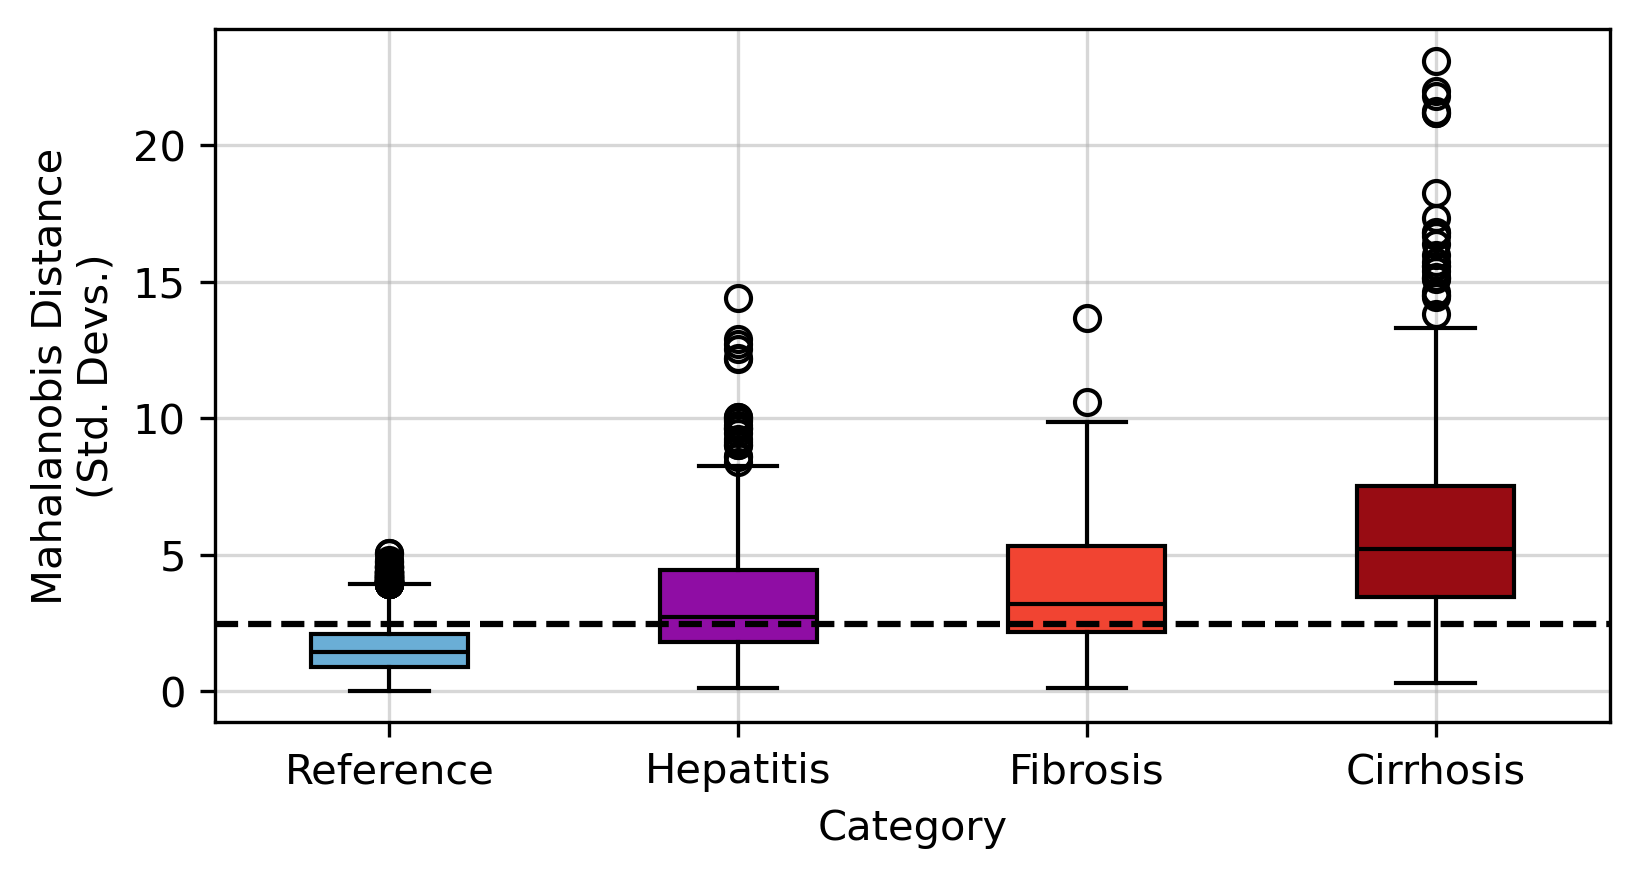

In [5]:
import numpy as np
import pandas as pd
# from scipy.stats import chi2
import matplotlib.pyplot as plt
import matplotlib as mpl
import helpers as lib
from itertools import combinations

# load data
data_path = '../../data/liver/'
df = pd.read_csv(f"{data_path}/liver_preprocessed.csv")
analytes = df.columns[3:]  # list of analytes
analytes = analytes.drop(['cholesterol', 'cholinesterase', 'alkaline phosphatase'])  # remove 3 analytes
log_analytes = list(analytes)  # transform all analytes

# load results
results = lib.load_pickle('./results.pkl')


# def get_probs(points):
#     """ Calculates probability of observation based on distance from centroid of multivariate normal
#     """
#     probs = []
#     for point in points:
#         mahalanobis_distance = np.sqrt((point - mean).T @ inv_cov @ (point - mean))
#         squared_distance = mahalanobis_distance ** 2
#         degrees_of_freedom = len(mean)
#         probability = 1 - chi2.cdf(squared_distance, degrees_of_freedom)
#         probs.append(probability)
#     return probs


def get_probs(points):
    """ Calculates mahalanobis distances
    """
    dists = []
    for point in points:
        dist = np.sqrt((point - mean).T @ inv_cov @ (point - mean))
        dists.append(dist)
    return dists


unique_pairs = sorted(list(set(combinations(analytes, 2))))  # get all pairs of analytes
keys = ['reference', 'hepatitis', 'fibrosis', 'cirrhosis']
pdfs = {i: [] for i in keys}
results = {tuple(i['pair']): i for i in results}
model_source = 'direct'
for gender in ['M', 'F']:  # loop genders
    for pair in unique_pairs:  # loop pairs
                
        # get data
        data, labels = lib.get_data(df, list(pair), gender, log_analytes, outlier_removal=False, transform=True)
        
        # get gaussian
        mean = results[pair][model_source]['model'][0]
        cov = results[pair][model_source]['model'][1]
        inv_cov = np.linalg.inv(cov)

        pdfs['reference'] += list(get_probs(data[labels == 'reference']))
        # pdfs['abnormal'] += list(get_probs(data[labels == 'abnormal']))
        pdfs['hepatitis'] += list(get_probs(data[labels == 'hepatitis']))
        pdfs['fibrosis'] += list(get_probs(data[labels == 'fibrosis']))
        pdfs['cirrhosis'] += list(get_probs(data[labels == 'cirrhosis']))

colors = [mpl.colormaps['Blues'](0.5), mpl.colormaps['plasma'](0.3), mpl.colormaps['Reds'](0.6), mpl.colormaps['Reds'](0.9)]
plt.figure(figsize=(6, 3), dpi=300)
bplot = plt.boxplot(
    [pdfs[key] for key in keys],
    tick_labels=[i.capitalize() for i in keys],
    medianprops={'color': 'k'},
    patch_artist=True,  # fill with color
    showfliers=True)
# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('Category')
plt.ylabel('Mahalanobis Distance\n(Std. Devs.)')
plt.axhline(2.448, c='k', linestyle='--')
plt.grid(alpha=0.5);
plt.savefig('stage_vs_abnormality.png')


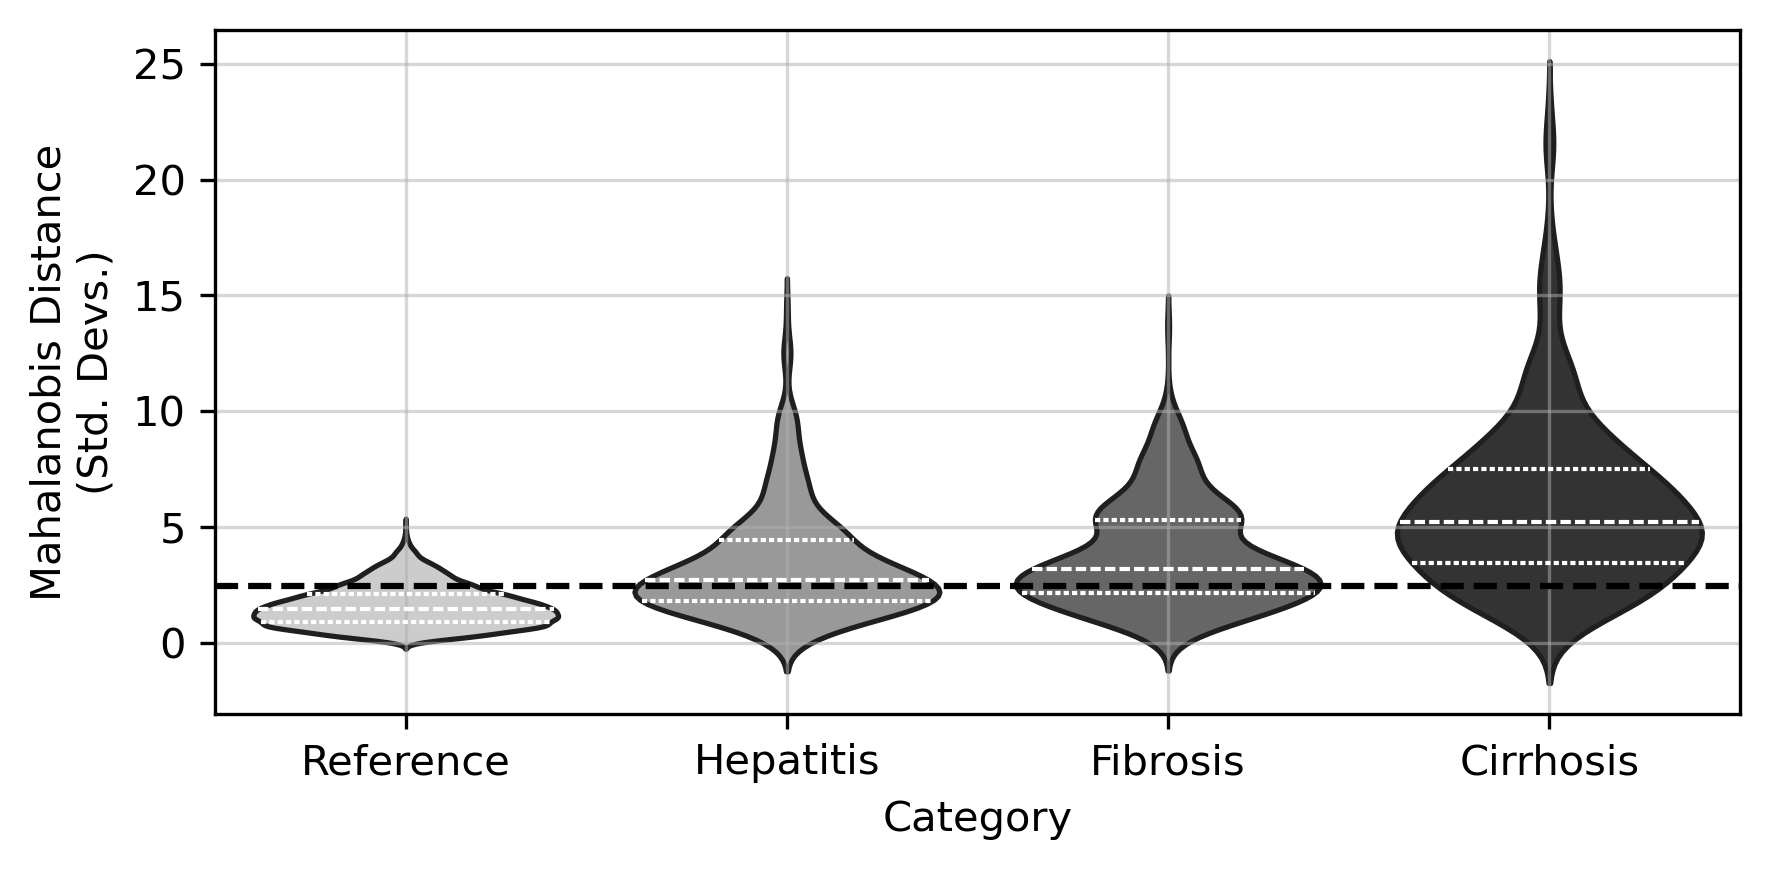

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# flatten data and labels into a DataFrame for Seaborn
plot_df = pd.DataFrame({
    'Category': [key.capitalize() for key in keys for _ in range(len(pdfs[key]))],
    'Mahalanobis': [val for key in keys for val in pdfs[key]]
})

plt.figure(figsize=(6,3), dpi=300)

palette = sns.color_palette("binary", n_colors=4)  # muted professional tones

sns.violinplot(
    data=plot_df,
    x='Category',
    y='Mahalanobis',
    hue='Category',
    palette=palette,
    inner='quartile',
    inner_kws=dict(color='white', linewidth=1),  # quartile lines white
    legend=False
)

plt.xlabel('Category')
plt.ylabel('Mahalanobis Distance\n(Std. Devs.)')
plt.axhline(2.448, c='k', linestyle='--')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('stage_vs_abnormality_violin.png')
plt.show()

